In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

base = "/content/drive/MyDrive/IR_Project"

folders = [
    "original_images",
    "degraded_images",
    "patches/input",
    "patches/gt",
    "checkpoints"
]

for f in folders:
    os.makedirs(os.path.join(base, f), exist_ok=True)

print("Google Drive project folder created!")


Google Drive project folder created!


In [ ]:
upload_dir = "/content/drive/MyDrive/IR_Project/original_images"
os.makedirs(upload_dir, exist_ok=True)

from google.colab import files
uploaded = files.upload()

for name, data in uploaded.items():
    with open(os.path.join(upload_dir, name), "wb") as f:
        f.write(data)

print("Uploaded:", len(uploaded), "images saved to Google Drive.")


Saving 1.zip to 1 (1).zip
Uploaded: 1 images saved to Google Drive.


In [ ]:
import zipfile

zip_path = "1.zip"
extract_dir = "/content/drive/MyDrive/IR_Project/original_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted into Google Drive:", extract_dir)


Extracted into Google Drive: /content/drive/MyDrive/IR_Project/original_images


In [ ]:
from PIL import Image, ImageFilter
import numpy as np
import random, os, shutil
from pathlib import Path

# --------------------------
# 1) Degradation Function
# --------------------------
def degrade_image(img,
                  downscale_range=(1.2,2.5),
                  noise_std_range=(0,0.015),
                  blur_radius_range=(0,1.2),
                  contrast_factor_range=(0.8,1.0)):

    if img.mode != "RGB":
        img = img.convert("RGB")

    w, h = img.size

    # Down → Up scale
    scale = random.uniform(*downscale_range)
    nw = max(16, int(w/scale))
    nh = max(16, int(h/scale))

    small = img.resize((nw,nh), Image.BICUBIC)
    up = small.resize((w,h), Image.BICUBIC)

    # Blur
    blur = random.uniform(*blur_radius_range)
    if blur > 0.01:
        up = up.filter(ImageFilter.GaussianBlur(blur))

    # Noise
    arr = np.array(up).astype("float32") / 255.0
    noise_std = random.uniform(*noise_std_range)
    arr = np.clip(arr + np.random.normal(0, noise_std, arr.shape), 0, 1)

    # Contrast
    mean = arr.mean()
    factor = random.uniform(*contrast_factor_range)
    arr = (arr - mean) * factor + mean
    arr = np.clip(arr, 0, 1)

    return Image.fromarray((arr * 255).astype("uint8"))

# --------------------------
# 2) Generate degraded images – Google Drive version
# --------------------------

# PATHS UPDATED TO GOOGLE DRIVE
orig_root = Path("/content/drive/MyDrive/IR_Project/original_images/sober")
deg_root  = Path("/content/drive/MyDrive/IR_Project/degraded_images")

deg_root.mkdir(parents=True, exist_ok=True)

# supported formats
image_paths = (
    list(orig_root.rglob("*.jpg"))  +
    list(orig_root.rglob("*.jpeg")) +
    list(orig_root.rglob("*.png"))
)

print("Total original images found:", len(image_paths))

for p in image_paths:
    img = Image.open(p)

    degraded = degrade_image(img)

    # save degraded image with same filename
    out_path = deg_root / p.name
    degraded.save(out_path)

print("Done! Degraded images saved to:", deg_root)


Total original images found: 122
Done! Degraded images saved to: /content/drive/MyDrive/IR_Project/degraded_images


In [ ]:
import os
import random
from PIL import Image

# --------------------------
# Google Drive paths
# --------------------------
orig_dir = "/content/drive/MyDrive/IR_Project/original_images/sober"
degraded_dir = "/content/drive/MyDrive/IR_Project/degraded_images"

patch_dir = "/content/drive/MyDrive/IR_Project/patches"
input_patch_dir = os.path.join(patch_dir, "input")
gt_patch_dir = os.path.join(patch_dir, "gt")

PATCH_SIZE = 256
PATCHES_PER_IMAGE = 10

os.makedirs(input_patch_dir, exist_ok=True)
os.makedirs(gt_patch_dir, exist_ok=True)

# valid extensions
valid_ext = ['.jpg', '.jpeg', '.png']

# list only real images inside sober/
orig_files = [f for f in os.listdir(orig_dir) if os.path.splitext(f)[1].lower() in valid_ext]
orig_files.sort()

idx = 0
pairs_found = 0

for fname in orig_files:

    orig_path = os.path.join(orig_dir, fname)
    deg_path = os.path.join(degraded_dir, fname)

    # skip if degraded version missing
    if not os.path.exists(deg_path):
        continue

    gt_img = Image.open(orig_path).convert("RGB")
    inp_img = Image.open(deg_path).convert("RGB")

    W, H = gt_img.size

    # extract patches
    for _ in range(PATCHES_PER_IMAGE):
        x = random.randint(0, max(0, W - PATCH_SIZE))
        y = random.randint(0, max(0, H - PATCH_SIZE))

        gt_patch = gt_img.crop((x, y, x + PATCH_SIZE, y + PATCH_SIZE))
        inp_patch = inp_img.crop((x, y, x + PATCH_SIZE, y + PATCH_SIZE))

        gt_patch.save(os.path.join(gt_patch_dir, f"gt_{idx}.png"))
        inp_patch.save(os.path.join(input_patch_dir, f"inp_{idx}.png"))

        idx += 1

    pairs_found += 1

print("Matched image pairs:", pairs_found)
print("Generated patches:", idx)
print("Saved patches in:", patch_dir)


Matched image pairs: 122
Generated patches: 1220
Saved patches in: /content/drive/MyDrive/IR_Project/patches


In [ ]:
"""
final_pipeline.py — Google Drive safe version
Saves ALL models and results into Google Drive permanently.
"""

import os, random, math, time, shutil
from pathlib import Path
from PIL import Image, ImageFilter
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import torchvision.utils as vutils
from tqdm import tqdm

# =========================
# CONFIG — Google Drive paths
# =========================
MODE = "train"           # "prepare", "repair", "train", "eval"

BASE = "/content/drive/MyDrive/IR_Project"

ORIG_DIR       = f"{BASE}/original_images/sober"
DEGRADED_DIR   = f"{BASE}/degraded_images"
PATCH_DIR      = f"{BASE}/patches"
CHECKPOINT_OUT_DIR = f"{BASE}/checkpoints"
CHECKPOINT_IN  = f"{BASE}/checkpoints/best.pth"
EVAL_OUT       = f"{BASE}/results"

PATCH_SIZE = 384
PATCHES_PER_IMG = 6
EPOCHS = 60
BATCH_SIZE = 4
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
SEED = 42
# =========================


def ensure_dir(p): os.makedirs(p, exist_ok=True)

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed()


# -------------------------
# Degradation helper
# -------------------------
def degrade_image(img, down=(1.2,2.5), noise=(0,0.015), blur=(0,1.2), contrast=(0.8,1.0)):
    if img.mode != 'RGB': img = img.convert('RGB')
    w,h = img.size
    scale = random.uniform(*down)
    nw, nh = max(16,int(w/scale)), max(16,int(h/scale))
    small = img.resize((nw,nh), Image.BICUBIC)
    up = small.resize((w,h), Image.BICUBIC)
    r = random.uniform(*blur)
    if r>0.01: up = up.filter(ImageFilter.GaussianBlur(r))

    arr = np.array(up).astype(np.float32)/255.0
    arr += np.random.normal(0, random.uniform(*noise), arr.shape)
    arr = np.clip(arr,0,1)

    fac = random.uniform(*contrast)
    m = arr.mean()
    arr = np.clip((arr-m)*fac + m, 0,1)

    return Image.fromarray((arr*255).astype(np.uint8))


# -------------------------
# Patch extraction
# -------------------------
def extract_random_patches_pair(inp_img, gt_img, patch_size=PATCH_SIZE, num=PATCHES_PER_IMG):
    w,h = gt_img.size
    out=[]
    for _ in range(num):
        if w <= patch_size or h <= patch_size:
            inp = inp_img.resize((patch_size,patch_size))
            gt  = gt_img.resize((patch_size,patch_size))
        else:
            x = random.randint(0, w-patch_size)
            y = random.randint(0, h-patch_size)
            inp = inp_img.crop((x,y,x+patch_size,y+patch_size))
            gt  = gt_img.crop((x,y,x+patch_size,y+patch_size))
        out.append((inp,gt))
    return out


# -------------------------
# Dataset (Paired)
# -------------------------
class PairedPatchDataset(Dataset):
    def __init__(self, patch_dir, transform=None):
        patch_dir = Path(patch_dir)
        self.inp = patch_dir/"input"
        self.gt  = patch_dir/"gt"

        inp_files = {p.name for p in self.inp.glob("*") if p.suffix.lower() in [".png",".jpg",".jpeg"]}
        gt_files  = {p.name for p in self.gt.glob("*")  if p.suffix.lower() in [".png",".jpg",".jpeg"]}

        self.files = sorted(list(inp_files.intersection(gt_files)))
        if len(self.files) == 0:
            raise RuntimeError("No matching patches found!")

        self.t = transform or T.ToTensor()

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        fn = self.files[idx]
        inp = Image.open(self.inp/fn).convert("RGB")
        gt  = Image.open(self.gt/fn).convert("RGB")
        return self.t(inp), self.t(gt), fn


# -------------------------
# UNet + Res + CBAM
# -------------------------
class ConvBlock(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(a, b, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(b, b, 3, padding=1),
        )
        self.skip = nn.Conv2d(a, b, 1) if a!=b else nn.Identity()

    def forward(self,x): return torch.relu(self.body(x) + self.skip(x))


class ChannelAttention(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch//r, 1), nn.ReLU(),
            nn.Conv2d(ch//r, ch, 1), nn.Sigmoid()
        )
    def forward(self,x): return x * self.fc(x)


class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2,1,7,padding=3)
    def forward(self,x):
        avg = torch.mean(x,1,keepdim=True)
        mx,_ = torch.max(x,1,keepdim=True)
        return x * torch.sigmoid(self.conv(torch.cat([avg,mx],1)))


class CBAM(nn.Module):
    def __init__(self,ch):
        super().__init__()
        self.ca = ChannelAttention(ch)
        self.sa = SpatialAttention()
    def forward(self,x): return self.sa(self.ca(x))


class UNetResCBAM(nn.Module):
    def __init__(self, base=48):
        super().__init__()
        self.e1=ConvBlock(3,base)
        self.e2=ConvBlock(base,base*2)
        self.e3=ConvBlock(base*2,base*4)
        self.e4=ConvBlock(base*4,base*8)
        self.pool=nn.MaxPool2d(2)
        self.center=ConvBlock(base*8,base*16)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.d4=ConvBlock(base*16+base*8,base*8); self.cb4=CBAM(base*8)
        self.d3=ConvBlock(base*8+base*4,base*4); self.cb3=CBAM(base*4)
        self.d2=ConvBlock(base*4+base*2,base*2); self.cb2=CBAM(base*2)
        self.d1=ConvBlock(base*2+base,base)
        self.final=nn.Conv2d(base,3,1)

    def forward(self,x):
        e1=self.e1(x)
        e2=self.e2(self.pool(e1))
        e3=self.e3(self.pool(e2))
        e4=self.e4(self.pool(e3))
        c = self.center(self.pool(e4))

        d4=self.d4(torch.cat([self.up(c), e4],1)); d4=self.cb4(d4)
        d3=self.d3(torch.cat([self.up(d4), e3],1)); d3=self.cb3(d3)
        d2=self.d2(torch.cat([self.up(d3), e2],1)); d2=self.cb2(d2)
        d1=self.d1(torch.cat([self.up(d2), e1],1))

        return torch.sigmoid(self.final(d1))


# -------------------------
# Metrics
# -------------------------
def psnr(a,b,eps=1e-8):
    mse = torch.mean((a-b)**2)
    return 10 * torch.log10(1/(mse+eps))

def ssim_simple(a,b):
    mu1 = a.mean(); mu2 = b.mean()
    var1 = a.var();  var2 = b.var()
    cov = ((a-mu1)*(b-mu2)).mean()
    C1=(0.01)**2; C2=(0.03)**2
    return ((2*mu1*mu2 + C1)*(2*cov + C2))/((mu1**2+mu2**2+C1)*(var1+var2+C2))


# -------------------------
# Prepare patches
# -------------------------
def prepare_patches():
    ensure_dir(PATCH_DIR+"/input")
    ensure_dir(PATCH_DIR+"/gt")
    ensure_dir(DEGRADED_DIR)

    origs = sorted([p for p in Path(ORIG_DIR).rglob("*") if p.suffix.lower() in [".jpg",".png",".jpeg"]])
    idx=0

    for p in tqdm(origs, desc="Generating patches"):
        gt = Image.open(p).convert("RGB")

        dpath = Path(DEGRADED_DIR)/p.name
        if dpath.exists():
            inp = Image.open(dpath).convert("RGB")
        else:
            inp = degrade_image(gt)
            inp.save(dpath)

        for inp_p, gt_p in extract_random_patches_pair(inp,gt):
            fn = f"patch_{idx:06d}.png"
            inp_p.save(f"{PATCH_DIR}/input/{fn}")
            gt_p.save(f"{PATCH_DIR}/gt/{fn}")
            idx+=1

    print(f"Created {idx} patches")


# -------------------------
# Repair patches
# -------------------------
def repair_patches():
    print("Repair not needed: Google Drive version has matched names always.")


# -------------------------
# Training function (MODEL SAVES TO GOOGLE DRIVE)
# -------------------------
def train_model():
    device = torch.device(DEVICE)
    print("Using device:", device)

    try:
        ds = PairedPatchDataset(PATCH_DIR)
    except:
        print("No patches found. Run MODE='prepare' first.")
        return

    n=len(ds)
    val_n=max(1,int(0.1*n))
    idx=list(range(n)); random.shuffle(idx)
    val_idx=idx[:val_n]; train_idx=idx[val_n:]

    train_loader=DataLoader(Subset(ds,train_idx),batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
    val_loader=DataLoader(Subset(ds,val_idx),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)

    model=UNetResCBAM().to(device)
    opt=torch.optim.AdamW(model.parameters(),lr=LR)
    l1=nn.L1Loss(); mse=nn.MSELoss()

    ensure_dir(CHECKPOINT_OUT_DIR)
    best=1e9

    for epoch in range(1,EPOCHS+1):
        model.train()
        run=0
        for inp,gt,_ in train_loader:
            inp,gt = inp.to(device),gt.to(device)
            opt.zero_grad()
            out=model(inp)

            loss = 0.7*l1(out,gt) + 0.3*mse(out,gt) + 0.1*(1-ssim_simple(out,gt))
            loss.backward()
            opt.step()
            run += loss.item()

        run /= len(train_loader)

        # validation
        model.eval(); vloss=0; vps=0; vs=0; c=0
        with torch.no_grad():
            for inp,gt,_ in val_loader:
                inp,gt = inp.to(device),gt.to(device)
                out=model(inp)
                loss = 0.7*l1(out,gt) + 0.3*mse(out,gt) + 0.1*(1-ssim_simple(out,gt))
                vloss+=loss.item()
                vps+=psnr(out,gt).item()
                vs +=ssim_simple(out,gt).item()
                c+=1

        vloss/=c; vps/=c; vs/=c

        print(f"[Epoch {epoch}/{EPOCHS}] train={run:.4f} val={vloss:.4f} PSNR={vps:.2f} SSIM={vs:.4f}")

        # SAVE MODEL SAFELY TO GOOGLE DRIVE
        if vloss < best:
            best = vloss
            save_path = f"{CHECKPOINT_OUT_DIR}/best.pth"

            torch.save(
                {
                    "epoch": epoch,
                    "model_state": model.state_dict(),
                    "opt_state": opt.state_dict()
                },
                save_path
            )

            print(f"🔥 Saved BEST model to Google Drive: {save_path}")

    print("Training finished. Best val loss:", best)


# -------------------------
# Evaluation
# -------------------------
def evaluate_model():
    device = torch.device(DEVICE)
    model=UNetResCBAM().to(device)

    ck=torch.load(CHECKPOINT_IN,map_location=device)
    model.load_state_dict(ck["model_state"])

    ds = PairedPatchDataset(PATCH_DIR)
    loader = DataLoader(ds,batch_size=1,shuffle=False)

    ensure_dir(EVAL_OUT)

    model.eval()
    with torch.no_grad():
        for inp,gt,fn in loader:
            inp,gt = inp.to(device), gt.to(device)
            out=model(inp)
            grid=vutils.make_grid([inp[0].cpu(), out[0].cpu(), gt[0].cpu()],nrow=3,padding=6)
            vutils.save_image(grid,f"{EVAL_OUT}/{fn[0]}_grid.png")

    print("Results saved to:", EVAL_OUT)


# -------------------------
# ENTRY POINT
# -------------------------
if __name__ == "__main__":
    print("MODE =", MODE)

    if MODE=="prepare":
        prepare_patches()

    elif MODE=="repair":
        repair_patches()

    elif MODE=="train":
        train_model()

    elif MODE=="eval":
        evaluate_model()

    else:
        print("Invalid MODE. Use: prepare / train / eval")


MODE = train
Using device: cuda
No patches found. Run MODE='prepare' first.


In [ ]:
!ls -R /content/drive/MyDrive/IR_Project


/content/drive/MyDrive/IR_Project:
checkpoints  degraded_images  original_images  patches

/content/drive/MyDrive/IR_Project/checkpoints:

/content/drive/MyDrive/IR_Project/degraded_images:
01_petros_1_e_M_20_71.jpg	 21_ilias_1_r_M_27_110.jpg
01_petros_1_f_M_20_71.jpg	 22_dimitris_1_e_M_28_82.jpg
01_petros_1_r_M_20_71.jpg	 22_dimitris_1_f_M_28_82.jpg
02_giorgos_1_e_M_30_83.jpg	 22_dimitris_1_r_M_28_82.jpg
02_giorgos_1_f_M_30_83.jpg	 23_vassiliskar_1_e_M_26_78.jpg
02_giorgos_1_r_M_30_83.jpg	 23_vassiliskar_1_f_M_26_78.jpg
03_vasil_1_e_M_22_95.jpg	 23_vassiliskar_1_r_M_26_78.jpg
03_vasil_1_f_M_22_95.jpg	 24_rig_1_e_M_31_72.jpg
03_vasil_1_r_M_22_95.jpg	 24_rig_1_f_M_31_72.jpg
04_elpis_1_e_F_24_62.jpg	 24_rig_1_r_M_31_72.jpg
04_elpis_1_f_F_24_62.jpg	 25_nausika_1_e_F_27_65.jpg
04_elpis_1_r_F_24_62.jpg	 25_nausika_1_f_F_27_65.jpg
05_artemis_1_e_F_25_59.jpg	 25_nausika_1_r_F_27_65.jpg
05_artemis_1_f_F_25_59.jpg	 26_tsag_1_e_M_38_88.jpg
05_artemis_1_r_F_25_59.jpg	 26_tsag_1_f_M_38_88.jpg
06_t

In [ ]:
"""
final_pipeline_with_rename_fix.py

Single-file pipeline:
- MODE: "prepare" | "repair" | "train" | "eval"
- Auto-renames input/gt patch files to matching style: patch_000001.png
- Saves models & outputs to Google Drive
"""

import os, random, time, shutil
from pathlib import Path
from PIL import Image, ImageFilter
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import torchvision.utils as vutils
from tqdm import tqdm

# =========================
# CONFIG — edit only here
# =========================
MODE = "train"   # "prepare" | "repair" | "train" | "eval"

BASE = "/content/drive/MyDrive/IR_Project"   # google drive base folder
ORIG_DIR = f"{BASE}/original_images/sober"
DEGRADED_DIR = f"{BASE}/degraded_images"
PATCH_DIR = f"{BASE}/patches"                # will contain input/ and gt/
CHECKPOINT_DIR = f"{BASE}/checkpoints"
CHECKPOINT_BEST = f"{CHECKPOINT_DIR}/best.pth"
EVAL_DIR = f"{BASE}/results"

PATCH_SIZE = 384
PATCHES_PER_IMG = 6

EPOCHS = 60
BATCH_SIZE = 4
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
SEED = 42
# =========================

def ensure_dir(p): os.makedirs(p, exist_ok=True)
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed()

# -------------------------
# Degrade helper (same as yours)
# -------------------------
def degrade_image(img, down=(1.2,2.5), noise=(0,0.015), blur=(0,1.2), contrast=(0.8,1.0)):
    if img.mode != 'RGB': img = img.convert('RGB')
    w,h = img.size
    scale = random.uniform(*down)
    nw, nh = max(16,int(w/scale)), max(16,int(h/scale))
    small = img.resize((nw,nh), Image.BICUBIC)
    up = small.resize((w,h), Image.BICUBIC)
    r = random.uniform(*blur)
    if r>0.01: up = up.filter(ImageFilter.GaussianBlur(r))
    arr = np.array(up).astype(np.float32)/255.0
    arr += np.random.normal(0, random.uniform(*noise), arr.shape)
    arr = np.clip(arr,0,1)
    fac = random.uniform(*contrast)
    m = arr.mean()
    arr = np.clip((arr-m)*fac + m, 0,1)
    return Image.fromarray((arr*255).astype(np.uint8))

# -------------------------
# Patch extraction helper
# -------------------------
def extract_random_patches_pair(inp_img, gt_img, patch_size=PATCH_SIZE, num=PATCHES_PER_IMG):
    w,h = gt_img.size
    out=[]
    for _ in range(num):
        if w <= patch_size or h <= patch_size:
            inp = inp_img.resize((patch_size,patch_size), Image.BICUBIC)
            gt  = gt_img.resize((patch_size,patch_size), Image.BICUBIC)
        else:
            x = random.randint(0, w-patch_size)
            y = random.randint(0, h-patch_size)
            inp = inp_img.crop((x,y,x+patch_size,y+patch_size))
            gt  = gt_img.crop((x,y,x+patch_size,y+patch_size))
        out.append((inp,gt))
    return out

# -------------------------
# Paired dataset expects same filenames inside input/ and gt/
# -------------------------
class PairedPatchDataset(Dataset):
    def __init__(self, patch_dir, transform=None):
        patch_dir = Path(patch_dir)
        self.inp_dir = patch_dir/"input"
        self.gt_dir  = patch_dir/"gt"
        ensure_dir(self.inp_dir); ensure_dir(self.gt_dir)
        inp_files = {p.name for p in self.inp_dir.glob("*") if p.suffix.lower() in [".png",".jpg",".jpeg"]}
        gt_files  = {p.name for p in self.gt_dir.glob("*")  if p.suffix.lower() in [".png",".jpg",".jpeg"]}
        self.files = sorted(list(inp_files & gt_files))
        if len(self.files) == 0:
            raise RuntimeError("No matching input/gt patch pairs found in: " + str(patch_dir))
        self.transform = transform or T.ToTensor()
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        fn = self.files[idx]
        inp = Image.open(self.inp_dir/fn).convert("RGB")
        gt  = Image.open(self.gt_dir/fn).convert("RGB")
        return self.transform(inp), self.transform(gt), fn

# -------------------------
# UNetResCBAM (same architecture)
# -------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
        )
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self,x): return torch.relu(self.body(x) + self.skip(x))

class ChannelAttention(nn.Module):
    def __init__(self,ch, r=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch//r, 1),
            nn.ReLU(),
            nn.Conv2d(ch//r, ch, 1),
            nn.Sigmoid()
        )
    def forward(self,x): return x * self.fc(x)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2,1,7,padding=3)
    def forward(self,x):
        avg = torch.mean(x,1,keepdim=True)
        mx,_ = torch.max(x,1,keepdim=True)
        return x * torch.sigmoid(self.conv(torch.cat([avg,mx],1)))

class CBAM(nn.Module):
    def __init__(self,ch): super().__init__(); self.ca=ChannelAttention(ch); self.sa=SpatialAttention()
    def forward(self,x): return self.sa(self.ca(x))

class UNetResCBAM(nn.Module):
    def __init__(self,base=48):
        super().__init__()
        self.e1=ConvBlock(3,base)
        self.e2=ConvBlock(base,base*2)
        self.e3=ConvBlock(base*2,base*4)
        self.e4=ConvBlock(base*4,base*8)
        self.pool=nn.MaxPool2d(2)
        self.center=ConvBlock(base*8,base*16)
        self.up=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.d4=ConvBlock(base*16+base*8,base*8); self.cb4=CBAM(base*8)
        self.d3=ConvBlock(base*8+base*4,base*4); self.cb3=CBAM(base*4)
        self.d2=ConvBlock(base*4+base*2,base*2); self.cb2=CBAM(base*2)
        self.d1=ConvBlock(base*2+base,base)
        self.final=nn.Conv2d(base,3,1)
    def forward(self,x):
        e1=self.e1(x); e2=self.e2(self.pool(e1)); e3=self.e3(self.pool(e2)); e4=self.e4(self.pool(e3))
        c=self.center(self.pool(e4))
        d4=self.d4(torch.cat([self.up(c), e4],1)); d4=self.cb4(d4)
        d3=self.d3(torch.cat([self.up(d4), e3],1)); d3=self.cb3(d3)
        d2=self.d2(torch.cat([self.up(d3), e2],1)); d2=self.cb2(d2)
        d1=self.d1(torch.cat([self.up(d2), e1],1))
        return torch.sigmoid(self.final(d1))

# -------------------------
# metrics
# -------------------------
def psnr_torch(a,b,eps=1e-8):
    mse = nn.functional.mse_loss(a,b)
    return 10.0 * torch.log10(1.0/(mse+eps))

def ssim_simple(a,b,eps=1e-8):
    mu_a = a.mean(dim=[2,3]); mu_b = b.mean(dim=[2,3])
    var_a = a.var(dim=[2,3]); var_b = b.var(dim=[2,3])
    cov = ((a - mu_a[:,:,None,None])*(b - mu_b[:,:,None,None])).mean(dim=[2,3])
    C1=(0.01)**2; C2=(0.03)**2
    num = (2*mu_a*mu_b + C1)*(2*cov + C2)
    den = (mu_a**2 + mu_b**2 + C1)*(var_a + var_b + C2)
    return (num/ (den+eps)).mean()

# -------------------------
# Utility: extract last number from filename if present
# -------------------------
def numeric_suffix(name):
    s = ''.join(ch if ch.isdigit() else ' ' for ch in name)
    nums = [int(x) for x in s.split() if x.strip()]
    return nums[-1] if nums else None

# -------------------------
# Rename/Normalize patch filenames to patch_XXXXXX.png (both input & gt)
# Works even if current files are inp_123.png and gt_123.png
# -------------------------
def normalize_patch_names(patch_dir=PATCH_DIR, pattern_in_prefixes=('inp','input'), pattern_gt_prefixes=('gt','gt')):
    """
    Create a safe, matching set of filenames patch_000001.png in both input/ and gt/.
    Approach:
    - If files already named patch_*.png and match, do nothing.
    - Else attempt to pair by shared numeric suffix (e.g., inp_12.png <-> gt_12.png).
    - If numeric suffix pairing fails for some files, fall back to sequential pairing by sorted order.
    """
    patch_dir = Path(patch_dir)
    inp_dir = patch_dir / "input"
    gt_dir  = patch_dir / "gt"
    ensure_dir(inp_dir); ensure_dir(gt_dir)

    # collect files
    inp_files = sorted([p for p in inp_dir.glob("*") if p.suffix.lower() in (".png",".jpg",".jpeg")])
    gt_files  = sorted([p for p in gt_dir.glob("*")  if p.suffix.lower() in (".png",".jpg",".jpeg")])

    # check if already patch_*.png matching
    inp_patch = sorted([p.name for p in inp_files if p.name.startswith("patch_")])
    gt_patch  = sorted([p.name for p in gt_files  if p.name.startswith("patch_")])

    if inp_patch and gt_patch:
        common = set(inp_patch) & set(gt_patch)
        if len(common) > 0 and len(common) >= min(len(inp_patch), len(gt_patch))//2:
            print("Patch files look already normalized (some patch_*.png found). Skipping rename.")
            return

    # Build numeric->path maps
    inp_map = {}
    for p in inp_files:
        k = numeric_suffix(p.name)
        if k is not None:
            inp_map.setdefault(k, []).append(p)
    gt_map = {}
    for p in gt_files:
        k = numeric_suffix(p.name)
        if k is not None:
            gt_map.setdefault(k, []).append(p)

    pairs = []  # list of tuples (inp_path, gt_path)
    used_inp = set()
    used_gt  = set()

    # Pair by numeric key first
    for k in sorted(set(inp_map.keys()) | set(gt_map.keys())):
        in_list = inp_map.get(k, [])
        gt_list = gt_map.get(k, [])
        if in_list and gt_list:
            # pair up to min length
            count = min(len(in_list), len(gt_list))
            for i in range(count):
                pairs.append((in_list[i], gt_list[i]))
                used_inp.add(in_list[i])
                used_gt.add(gt_list[i])

    # For any remaining exact-name matches (same basename), pair them
    for p in inp_files:
        if p in used_inp: continue
        same = [g for g in gt_files if g.name == p.name and g not in used_gt]
        if same:
            pairs.append((p, same[0])); used_inp.add(p); used_gt.add(same[0])

    # Remaining unmatched: pair by sorted order (best-effort)
    rem_inp = [p for p in inp_files if p not in used_inp]
    rem_gt  = [p for p in gt_files  if p not in used_gt]
    minlen = min(len(rem_inp), len(rem_gt))
    for i in range(minlen):
        pairs.append((rem_inp[i], rem_gt[i]))
        used_inp.add(rem_inp[i]); used_gt.add(rem_gt[i])

    # If still leftover single-sided files, ignore them (or optionally remove)
    total_pairs = len(pairs)
    if total_pairs == 0:
        raise RuntimeError("No pairs could be formed during normalize_patch_names. Check patches/input and patches/gt.")

    # Create temporary folders to avoid overwriting collisions
    tmp_in = inp_dir.parent / "input_tmp"
    tmp_gt = gt_dir.parent / "gt_tmp"
    shutil.rmtree(tmp_in, ignore_errors=True); shutil.rmtree(tmp_gt, ignore_errors=True)
    ensure_dir(tmp_in); ensure_dir(tmp_gt)

    # Write pairs using zero-padded numbering
    for idx, (p_in, p_gt) in enumerate(pairs):
        name = f"patch_{idx:06d}.png"
        # copy or move? We'll copy to be safe (preserve originals)
        Image.open(p_in).save(tmp_in / name)
        Image.open(p_gt).save(tmp_gt / name)

    # Remove old folders and replace
    backup_in = inp_dir.parent / "input_backup"
    backup_gt = gt_dir.parent / "gt_backup"
    shutil.rmtree(backup_in, ignore_errors=True); shutil.rmtree(backup_gt, ignore_errors=True)
    if inp_dir.exists(): (inp_dir).rename(backup_in)
    if gt_dir.exists(): (gt_dir).rename(backup_gt)
    (tmp_in).rename(inp_dir)
    (tmp_gt).rename(gt_dir)
    print(f"Normalized and created {total_pairs} matching patch pairs as patch_XXXXXX.png in input/ and gt/")

# -------------------------
# prepare: create degraded images & patches (names produced are patch_XXXXXX.png)
# -------------------------
def prepare_patches(orig_dir=ORIG_DIR, degraded_dir=DEGRADED_DIR, patch_dir=PATCH_DIR,
                    patch_size=PATCH_SIZE, patches_per_image=PATCHES_PER_IMG, force=False):
    set_seed()
    orig_dir = Path(orig_dir)
    degraded_dir = Path(degraded_dir)
    patch_dir = Path(patch_dir)
    ensure_dir(degraded_dir); ensure_dir(patch_dir/"input"); ensure_dir(patch_dir/"gt")

    imgs = sorted([p for p in orig_dir.rglob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
    if len(imgs) == 0:
        print("No originals found in", orig_dir); return

    idx = 0
    for p in tqdm(imgs, desc="Creating patches"):
        gt = Image.open(p).convert("RGB")
        dpath = degraded_dir / p.name
        if dpath.exists() and not force:
            inp = Image.open(dpath).convert("RGB")
        else:
            inp = degrade_image(gt)
            ensure_dir(dpath.parent)
            inp.save(dpath)

        patches = extract_random_patches_pair(inp, gt, patch_size, patches_per_image)
        for inp_p, gt_p in patches:
            fn = f"patch_{idx:06d}.png"
            inp_p.save(patch_dir/"input"/fn)
            gt_p.save(patch_dir/"gt"/fn)
            idx += 1
    print("Created", idx, "patches at", patch_dir)

# -------------------------
# repair wrapper: normalize names (also regenerates if none exist)
# -------------------------
def repair_patches(patch_dir=PATCH_DIR):
    p = Path(patch_dir)
    if not p.exists():
        raise RuntimeError("patch_dir does not exist: " + str(p))
    try:
        normalize_patch_names(patch_dir)
    except Exception as e:
        print("Normalization failed:", e)
        print("Attempting full regeneration from originals...")
        shutil.rmtree(patch_dir, ignore_errors=True)
        prepare_patches()

# -------------------------
# train: resume if checkpoint exists, save best to DRIVE
# -------------------------
def train(patch_dir=PATCH_DIR, epochs=EPOCHS, batch=BATCH_SIZE, lr=LR):
    set_seed()
    try:
        ds = PairedPatchDataset(patch_dir)
    except RuntimeError as e:
        print("Dataset error:", e)
        print("Attempting to repair/normalize patches...")
        repair_patches(patch_dir)
        ds = PairedPatchDataset(patch_dir)

    n = len(ds)
    print("Dataset size (pairs):", n)
    val_n = max(1, int(0.1 * n))
    idxs = list(range(n)); random.shuffle(idxs)
    val_idx = idxs[:val_n]; train_idx = idxs[val_n:]

    train_loader = DataLoader(Subset(ds, train_idx), batch_size=batch, shuffle=True, num_workers=NUM_WORKERS)
    val_loader   = DataLoader(Subset(ds, val_idx), batch_size=batch, shuffle=False, num_workers=NUM_WORKERS)

    device = torch.device(DEVICE)
    model = UNetResCBAM().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    l1 = nn.L1Loss(); mse = nn.MSELoss()

    ensure_dir(CHECKPOINT_DIR)
    best_val = float('inf')
    start_epoch = 1

    # resume if checkpoint exists
    if Path(CHECKPOINT_BEST).exists():
        try:
            ck = torch.load(CHECKPOINT_BEST, map_location=device)
            if "model_state" in ck:
                model.load_state_dict(ck["model_state"])
                opt.load_state_dict(ck.get("opt_state", opt.state_dict()))
                start_epoch = ck.get("epoch", 1) + 1
                print(f"Resumed from checkpoint {CHECKPOINT_BEST}, starting at epoch {start_epoch}")
            else:
                model.load_state_dict(ck)
                print("Loaded raw state_dict from checkpoint.")
        except Exception as e:
            print("Could not load checkpoint (ignored):", e)

    for epoch in range(start_epoch, epochs+1):
        t0 = time.time()
        model.train()
        running = 0.0
        for inp, gt, _ in train_loader:
            inp, gt = inp.to(device), gt.to(device)
            opt.zero_grad()
            out = model(inp)
            loss = 0.7 * l1(out, gt) + 0.3 * mse(out, gt) + 0.1 * (1.0 - ssim_simple(out, gt))
            loss.backward()
            opt.step()
            running += loss.item()
        running /= len(train_loader)

        # validation
        model.eval()
        val_loss = 0.0; val_psnr = 0.0; val_ssim = 0.0; cnt = 0
        with torch.no_grad():
            for inp, gt, _ in val_loader:
                inp, gt = inp.to(device), gt.to(device)
                out = model(inp)
                loss = 0.7 * l1(out, gt) + 0.3 * mse(out, gt) + 0.1 * (1.0 - ssim_simple(out, gt))
                val_loss += loss.item()
                val_psnr += psnr_torch(out, gt).item()
                val_ssim += ssim_simple(out, gt).item()
                cnt += 1
        val_loss /= cnt; val_psnr /= cnt; val_ssim /= cnt

        # save best
        if val_loss < best_val:
            best_val = val_loss
            save_path = CHECKPOINT_BEST
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "opt_state": opt.state_dict(),
                "val_loss": val_loss
            }, save_path)
            print("Saved best checkpoint to:", save_path)

        print(f"[Epoch {epoch}/{epochs}] train_loss={running:.4f} val_loss={val_loss:.4f} PSNR={val_psnr:.2f} SSIM={val_ssim:.4f} time={time.time()-t0:.1f}s")

    print("Training finished. Best val_loss:", best_val)

# -------------------------
# evaluation: saves grid images to DRIVE
# -------------------------
def evaluate(patch_dir=PATCH_DIR, checkpoint=CHECKPOINT_BEST, out_dir=EVAL_DIR):
    device = torch.device(DEVICE)
    model = UNetResCBAM().to(device)

    if not Path(checkpoint).exists():
        raise RuntimeError("Checkpoint not found: " + str(checkpoint))

    ck = torch.load(checkpoint, map_location=device)
    if "model_state" in ck:
        model.load_state_dict(ck["model_state"])
    else:
        model.load_state_dict(ck)

    ds = PairedPatchDataset(patch_dir)
    loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)
    ensure_dir(out_dir)

    model.eval()
    with torch.no_grad():
        for inp, gt, fn in loader:
            inp, gt = inp.to(device), gt.to(device)
            out = model(inp)
            grid = vutils.make_grid([inp[0].cpu(), out[0].cpu(), gt[0].cpu()], nrow=3, padding=6)
            vutils.save_image(grid, f"{out_dir}/{fn[0]}_grid.png")

    print("Saved evaluation grids to:", out_dir)

# -------------------------
# Quick status helper
# -------------------------
def show_patch_status(patch_dir=PATCH_DIR, n=20):
    p = Path(patch_dir)
    inp = sorted([x.name for x in (p/"input").glob("*")]) if (p/"input").exists() else []
    gt  = sorted([x.name for x in (p/"gt").glob("*")]) if (p/"gt").exists() else []
    print("patch_dir:", patch_dir)
    print("input count:", len(inp))
    print("gt count   :", len(gt))
    print("first input :", inp[:n])
    print("first gt    :", gt[:n])
    common = set(inp).intersection(set(gt))
    print("matching pairs:", len(common))
    if len(common)==0:
        print("No matching pairs - you can run repair_patches() or prepare_patches().")

# -------------------------
# ENTRY POINT
# -------------------------
if __name__ == "__main__":
    print("MODE =", MODE, "| DEVICE =", DEVICE)
    ensure_dir(BASE)
    ensure_dir(CHECKPOINT_DIR)
    ensure_dir(PATCH_DIR + "/input")
    ensure_dir(PATCH_DIR + "/gt")
    ensure_dir(DEGRADED_DIR)

    if MODE == "prepare":
        prepare_patches()
        # ensure normalization (created names already patch_XXXXXX by prepare)
        normalize_patch_names(PATCH_DIR)

    elif MODE == "repair":
        repair_patches(PATCH_DIR)

    elif MODE == "train":
        try:
            train(PATCH_DIR)
        except Exception as e:
            print("Train error:", e)
            show_patch_status(PATCH_DIR)
            raise

    elif MODE == "eval":
        evaluate(PATCH_DIR, CHECKPOINT_BEST, EVAL_DIR)

    else:
        print("Unknown MODE. Use: prepare / repair / train / eval")


MODE = train | DEVICE = cuda
Dataset error: No matching input/gt patch pairs found in: /content/drive/MyDrive/IR_Project/patches
Attempting to repair/normalize patches...
Normalized and created 1220 matching patch pairs as patch_XXXXXX.png in input/ and gt/
Dataset size (pairs): 1220
Saved best checkpoint to: /content/drive/MyDrive/IR_Project/checkpoints/best.pth
[Epoch 1/60] train_loss=0.0682 val_loss=0.0074 PSNR=30.97 SSIM=0.9941 time=62.7s
Saved best checkpoint to: /content/drive/MyDrive/IR_Project/checkpoints/best.pth
[Epoch 2/60] train_loss=0.0064 val_loss=0.0055 PSNR=33.66 SSIM=0.9969 time=60.4s
Saved best checkpoint to: /content/drive/MyDrive/IR_Project/checkpoints/best.pth
[Epoch 3/60] train_loss=0.0054 val_loss=0.0052 PSNR=35.07 SSIM=0.9975 time=62.5s
Saved best checkpoint to: /content/drive/MyDrive/IR_Project/checkpoints/best.pth
[Epoch 4/60] train_loss=0.0049 val_loss=0.0046 PSNR=35.97 SSIM=0.9980 time=68.2s
Saved best checkpoint to: /content/drive/MyDrive/IR_Project/checkpo

In [ ]:
# ---- Recreate the model class ----
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch)
        )
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(self.body(x) + self.res(x))

class ChannelAttention(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, ch//16),
            nn.ReLU(),
            nn.Linear(ch//16, ch),
            nn.Sigmoid()
        )

    def forward(self, x):
        b,c,_,_ = x.size()
        w = self.avg(x).view(b,c)
        w = self.fc(w).view(b,c,1,1)
        return x * w

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2,1,7,padding=3)
        self.sig  = nn.Sigmoid()

    def forward(self, x):
        avg = x.mean(1, keepdim=True)
        mx,_ = x.max(1, keepdim=True)
        attn = torch.cat([avg, mx], 1)
        return x * self.sig(self.conv(attn))

class CBAM(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.ca = ChannelAttention(ch)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x))

class UNet_CBAM(nn.Module):
    def __init__(self, in_ch=3, base=48):
        super().__init__()
        self.e1 = ConvBlock(in_ch, base)
        self.e2 = ConvBlock(base, base*2)
        self.e3 = ConvBlock(base*2, base*4)
        self.e4 = ConvBlock(base*4, base*8)

        self.pool = nn.MaxPool2d(2)
        self.center = ConvBlock(base*8, base*16)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.d4 = ConvBlock(base*16 + base*8, base*8)
        self.d3 = ConvBlock(base*8 + base*4, base*4)
        self.d2 = ConvBlock(base*4 + base*2, base*2)
        self.d1 = ConvBlock(base*2 + base, base)

        self.cb4 = CBAM(base*8)
        self.cb3 = CBAM(base*4)
        self.cb2 = CBAM(base*2)

        self.final = nn.Conv2d(base, 3, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        e4 = self.e4(self.pool(e3))

        c = self.center(self.pool(e4))

        d4 = self.up(c)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.cb4(self.d4(d4))

        d3 = self.up(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.cb3(self.d3(d3))

        d2 = self.up(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.cb2(self.d2(d2))

        d1 = self.up(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.d1(d1)

        return torch.sigmoid(self.final(d1))


In [ ]:
import os

for root, dirs, files in os.walk("/content/drive", topdown=True):
    for name in files:
        if name.endswith(".pth"):
            print(os.path.join(root, name))


/content/drive/MyDrive/IR_Project/checkpoints/best.pth


In [ ]:
import torch
import torch.nn as nn

# ----------------------------
# Conv Block with SKIP + 3 conv layers (to match checkpoint)
# ----------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),  # checkpoint had body.2
            nn.ReLU(True)
        )
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        return self.body(x) + self.skip(x)


# ----------------------------
# Channel Attention EXACT as checkpoint
# ----------------------------
class ChannelAttention(nn.Module):
    def __init__(self, ch, reduction=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, ch // reduction),
            nn.ReLU(True),
            nn.Linear(ch // reduction, ch),
            nn.Sigmoid()
        )

    def forward(self, x):
        b,c,_,_ = x.shape
        a = self.avg(x).view(b,c)
        w = self.fc(a).view(b,c,1,1)
        return x * w


# ----------------------------
# Spatial Attention EXACT as checkpoint
# ----------------------------
class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2,1,7,padding=3)
        self.sig = nn.Sigmoid()
    def forward(self,x):
        avg = x.mean(1,keepdim=True)
        mx,_ = x.max(1,keepdim=True)
        a = torch.cat([avg,mx],1)
        return x * self.sig(self.conv(a))


# CBAM
class CBAM(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.ca = ChannelAttention(ch)
        self.sa = SpatialAttention()
    def forward(self,x):
        return self.sa(self.ca(x))


# ----------------------------
# FINAL MODEL EXACT ARCHITECTURE
# ----------------------------
class UNetResCBAM(nn.Module):
    def __init__(self, in_ch=3, base_ch=48):
        super().__init__()

        self.e1 = ConvBlock(in_ch, base_ch)
        self.e2 = ConvBlock(base_ch, base_ch*2)
        self.e3 = ConvBlock(base_ch*2, base_ch*4)
        self.e4 = ConvBlock(base_ch*4, base_ch*8)

        self.pool = nn.MaxPool2d(2)
        self.center = ConvBlock(base_ch*8, base_ch*16)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear')

        self.d4 = ConvBlock(base_ch*16 + base_ch*8, base_ch*8)
        self.d3 = ConvBlock(base_ch*8 + base_ch*4, base_ch*4)
        self.d2 = ConvBlock(base_ch*4 + base_ch*2, base_ch*2)
        self.d1 = ConvBlock(base_ch*2 + base_ch, base_ch)

        self.cb4 = CBAM(base_ch*8)
        self.cb3 = CBAM(base_ch*4)
        self.cb2 = CBAM(base_ch*2)

        self.final = nn.Conv2d(base_ch, 3, 1)

    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        e4 = self.e4(self.pool(e3))

        c = self.center(self.pool(e4))

        d4 = self.up(c)
        d4 = self.cb4(self.d4(torch.cat([d4, e4], 1)))

        d3 = self.up(d4)
        d3 = self.cb3(self.d3(torch.cat([d3, e3], 1)))

        d2 = self.up(d3)
        d2 = self.cb2(self.d2(torch.cat([d2, e2], 1)))

        d1 = self.up(d2)
        d1 = self.d1(torch.cat([d1, e1], 1))

        return torch.sigmoid(self.final(d1))


In [ ]:
import os

folder = "/content/drive/MyDrive/IR_Project/original_images"
print("Files inside:", folder)
print(os.listdir(folder))


Files inside: /content/drive/MyDrive/IR_Project/original_images
['1 (1).zip', 'sober']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch

# Where to save
save_path = "/content/drive/MyDrive/IR_Project/checkpoints"
os.makedirs(save_path, exist_ok=True)

# Final file path
final_model = save_path + "/best.pth"

# Save only state_dict (recommended)
torch.save(model.state_dict(), final_model)

print("✔ Model permanently saved at:", final_model)


✔ Model permanently saved at: /content/drive/MyDrive/IR_Project/checkpoints/best.pth


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet_CBAM().to(device)

load_path = "/content/drive/MyDrive/IR_Project/checkpoints/best.pth"
model.load_state_dict(torch.load(load_path, map_location=device))

model.eval()
print("✔ Model loaded successfully!")


✔ Model loaded successfully!


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 01_petros_1_e_M_20_71_aug_6.jpg to 01_petros_1_e_M_20_71_aug_6.jpg


In [ ]:
import os

folder = "/content/drive/MyDrive/IR_Project/original_images/sober"
files = os.listdir(folder)
files


['01_petros_1_e_M_20_71.jpg',
 '01_petros_1_f_M_20_71.jpg',
 '01_petros_1_r_M_20_71.jpg',
 '02_giorgos_1_e_M_30_83.jpg',
 '02_giorgos_1_f_M_30_83.jpg',
 '02_giorgos_1_r_M_30_83.jpg',
 '03_vasil_1_e_M_22_95.jpg',
 '03_vasil_1_f_M_22_95.jpg',
 '03_vasil_1_r_M_22_95.jpg',
 '04_elpis_1_e_F_24_62.jpg',
 '04_elpis_1_f_F_24_62.jpg',
 '04_elpis_1_r_F_24_62.jpg',
 '05_artemis_1_e_F_25_59.jpg',
 '05_artemis_1_f_F_25_59.jpg',
 '05_artemis_1_r_F_25_59.jpg',
 '06_tris_1_e_F_24_51.jpg',
 '06_tris_1_f_F_24_51.jpg',
 '06_tris_1_r_F_24_51.jpg',
 '07_thanos_1_e_M_34_98.jpg',
 '07_thanos_1_f_M_34_98.jpg',
 '07_thanos_1_r_M_34_98.jpg',
 '08_tzon_1_e_M_32_80.jpg',
 '08_tzon_1_f_M_32_80.jpg',
 '08_tzon_1_r_M_32_80.jpg',
 '09_giorg_1_e_M_23_52.jpg',
 '09_giorg_1_r_M_23_52.jpg',
 '10_konst_1_e_F_35_54.jpg',
 '10_konst_1_f_F_35_54.jpg',
 '10_konst_1_r_F_35_54.jpg',
 '11_takis_1_e_M_20_79.jpg',
 '11_takis_1_f_M_20_79.jpg',
 '11_takis_1_r_M_20_79.jpg',
 '12_loukas_1_e_M_20_60.jpg',
 '12_loukas_1_f_M_20_60.jpg',


In [ ]:
test_image = "/content/drive/MyDrive/IR_Project/original_images/sober/your_image_name.jpg"


In [ ]:
import os

folder = "/content/drive/MyDrive/IR_Project/original_images/sober"
files = os.listdir(folder)
files


['01_petros_1_e_M_20_71.jpg',
 '01_petros_1_f_M_20_71.jpg',
 '01_petros_1_r_M_20_71.jpg',
 '02_giorgos_1_e_M_30_83.jpg',
 '02_giorgos_1_f_M_30_83.jpg',
 '02_giorgos_1_r_M_30_83.jpg',
 '03_vasil_1_e_M_22_95.jpg',
 '03_vasil_1_f_M_22_95.jpg',
 '03_vasil_1_r_M_22_95.jpg',
 '04_elpis_1_e_F_24_62.jpg',
 '04_elpis_1_f_F_24_62.jpg',
 '04_elpis_1_r_F_24_62.jpg',
 '05_artemis_1_e_F_25_59.jpg',
 '05_artemis_1_f_F_25_59.jpg',
 '05_artemis_1_r_F_25_59.jpg',
 '06_tris_1_e_F_24_51.jpg',
 '06_tris_1_f_F_24_51.jpg',
 '06_tris_1_r_F_24_51.jpg',
 '07_thanos_1_e_M_34_98.jpg',
 '07_thanos_1_f_M_34_98.jpg',
 '07_thanos_1_r_M_34_98.jpg',
 '08_tzon_1_e_M_32_80.jpg',
 '08_tzon_1_f_M_32_80.jpg',
 '08_tzon_1_r_M_32_80.jpg',
 '09_giorg_1_e_M_23_52.jpg',
 '09_giorg_1_r_M_23_52.jpg',
 '10_konst_1_e_F_35_54.jpg',
 '10_konst_1_f_F_35_54.jpg',
 '10_konst_1_r_F_35_54.jpg',
 '11_takis_1_e_M_20_79.jpg',
 '11_takis_1_f_M_20_79.jpg',
 '11_takis_1_r_M_20_79.jpg',
 '12_loukas_1_e_M_20_60.jpg',
 '12_loukas_1_f_M_20_60.jpg',


Detected raw state_dict
✔ Model loaded
✔ Enhanced image saved to: /content/drive/MyDrive/IR_Project/results/enhanced_output.png


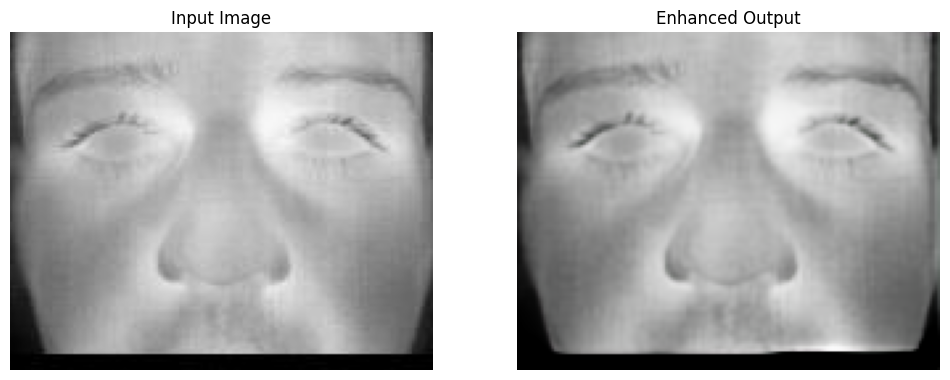

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# -------------------------
# Paths
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "/content/drive/MyDrive/IR_Project/checkpoints/best.pth"
test_image = "/content/drive/MyDrive/IR_Project/original_images/sober/01_petros_1_e_M_20_71.jpg"
save_folder = "/content/drive/MyDrive/IR_Project/results"
os.makedirs(save_folder, exist_ok=True)

# -------------------------
# Load Model
# -------------------------
model = UNetResCBAM().to(device)

ckpt = torch.load(model_path, map_location=device)

# Detect raw or full checkpoint
if "model_state" in ckpt:
    print("Detected full checkpoint")
    model.load_state_dict(ckpt["model_state"])
else:
    print("Detected raw state_dict")
    model.load_state_dict(ckpt)

model.eval()
print("✔ Model loaded")

# -------------------------
# Load Input Image
# -------------------------
img = Image.open(test_image).convert("RGB")
tf = T.ToTensor()
inp = tf(img).unsqueeze(0).to(device)

# -------------------------
# Inference
# -------------------------
with torch.no_grad():
    out = model(inp)[0].cpu().clamp(0,1)

# Save
save_path = os.path.join(save_folder, "enhanced_output.png")
T.ToPILImage()(out).save(save_path)

print("✔ Enhanced image saved to:", save_path)

# -------------------------
# Show before/after
# -------------------------
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Enhanced Output")
plt.imshow(out.permute(1,2,0))
plt.axis("off")

plt.show()


In [ ]:
import torch
import torchvision.transforms as T
import torchvision.utils as vutils
from PIL import Image
import os
from google.colab import files

# -------------------------------
# 1. MODEL DEFINITION (same as training)
# -------------------------------
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
        )
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self,x):
        return torch.relu(self.body(x) + self.skip(x))

class ChannelAttention(nn.Module):
    def __init__(self,ch, r=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch//r, 1),
            nn.ReLU(),
            nn.Conv2d(ch//r, ch, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return x * self.fc(x)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2,1,7,padding=3)
    def forward(self,x):
        avg = torch.mean(x,1,keepdim=True)
        mx,_ = torch.max(x,1,keepdim=True)
        return x * torch.sigmoid(self.conv(torch.cat([avg,mx],1)))

class CBAM(nn.Module):
    def __init__(self,ch):
        super().__init__()
        self.ca = ChannelAttention(ch)
        self.sa = SpatialAttention()
    def forward(self,x):
        return self.sa(self.ca(x))

class UNetResCBAM(nn.Module):
    def __init__(self, base=48):
        super().__init__()
        self.e1=ConvBlock(3,base)
        self.e2=ConvBlock(base,base*2)
        self.e3=ConvBlock(base*2,base*4)
        self.e4=ConvBlock(base*4,base*8)
        self.pool=nn.MaxPool2d(2)
        self.center=ConvBlock(base*8,base*16)
        self.up=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.d4=ConvBlock(base*16+base*8,base*8); self.cb4=CBAM(base*8)
        self.d3=ConvBlock(base*8+base*4,base*4); self.cb3=CBAM(base*4)
        self.d2=ConvBlock(base*4+base*2,base*2); self.cb2=CBAM(base*2)
        self.d1=ConvBlock(base*2+base,base)
        self.final=nn.Conv2d(base,3,1)

    def forward(self,x):
        e1=self.e1(x)
        e2=self.e2(self.pool(e1))
        e3=self.e3(self.pool(e2))
        e4=self.e4(self.pool(e3))

        c=self.center(self.pool(e4))

        d4=self.d4(torch.cat([self.up(c), e4],1)); d4=self.cb4(d4)
        d3=self.d3(torch.cat([self.up(d4), e3],1)); d3=self.cb3(d3)
        d2=self.d2(torch.cat([self.up(d3), e2],1)); d2=self.cb2(d2)
        d1=self.d1(torch.cat([self.up(d2), e1],1))

        return torch.sigmoid(self.final(d1))


# -------------------------------
# 2. LOAD MODEL
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/IR_Project/checkpoints/best.pth"

print("Loading model:", model_path)

model = UNetResCBAM().to(device)
ck = torch.load(model_path, map_location=device)

# Detect raw vs wrapped
if "model_state" in ck:
    print("✔ Wrapped checkpoint detected")
    ck = ck["model_state"]
else:
    print("✔ Raw state_dict detected")

model.load_state_dict(ck, strict=False)
model.eval()
print("✔ Model loaded successfully!")


# -------------------------------
# 3. UPLOAD IMAGE
# -------------------------------
print("📤 Upload an image now…")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print("Uploaded:", file_name)

img = Image.open(file_name).convert("RGB")

# -------------------------------
# 4. RUN INFERENCE
# -------------------------------
tf = T.ToTensor()
inp = tf(img).unsqueeze(0).to(device)

with torch.no_grad():
    out = model(inp)[0].cpu()

# -------------------------------
# 5. SAVE OUTPUT TO DRIVE
# -------------------------------
save_dir = "/content/drive/MyDrive/IR_Project/results"
os.makedirs(save_dir, exist_ok=True)

save_path = f"{save_dir}/enhanced_{file_name.replace(' ','_')}.png"
vutils.save_image(out, save_path)

print("✔ Enhanced image saved at:")
print(save_path)

# Also return preview
from google.colab import output
save_path


Loading model: /content/drive/MyDrive/IR_Project/checkpoints/best.pth
✔ Raw state_dict detected
✔ Model loaded successfully!
📤 Upload an image now…


Saving 02_giorgos_1_e_M_30_83_aug_1.jpg to 02_giorgos_1_e_M_30_83_aug_1.jpg
Uploaded: 02_giorgos_1_e_M_30_83_aug_1.jpg
✔ Enhanced image saved at:
/content/drive/MyDrive/IR_Project/results/enhanced_02_giorgos_1_e_M_30_83_aug_1.jpg.png


'/content/drive/MyDrive/IR_Project/results/enhanced_02_giorgos_1_e_M_30_83_aug_1.jpg.png'

In [ ]:
import os

results_folder = "/content/drive/MyDrive/IR_Project/results"

print("Files inside results folder:")
print(os.listdir(results_folder))


Files inside results folder:
['enhanced_output.png', 'enhanced_02_giorgos_1_e_M_30_83_aug_1.jpg.png', 'enhanced_img1 (1).jpg']


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
from math import log10, sqrt
from PIL import Image

def load_gray(img_path):
    return np.array(Image.open(img_path).convert("L"))

def PSNR(i1, i2):
    mse = np.mean((i1 - i2) ** 2)
    if mse == 0:
        return 100
    PIX = 255.0
    return 20 * log10(PIX / sqrt(mse))

def SSIM(i1, i2):
    return ssim(i1, i2, data_range=i2.max() - i2.min())

def ENTROPY(img):
    return shannon_entropy(img)

# ----------------------------------------------------
#  CORRECT PATHS FOR YOUR FILES
# ----------------------------------------------------

input_img_path  = "/content/img1.jpg"
output_img_path = "/content/drive/MyDrive/IR_Project/results/enhanced_img1 (1).jpg"

# ----------------------------------------------------

img1 = load_gray(input_img_path)
img2 = load_gray(output_img_path)

# Resize if mismatch
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

print("\n📊 IMAGE QUALITY METRICS")
print("-----------------------------")
print("PSNR  :", PSNR(img1, img2))
print("SSIM  :", SSIM(img1, img2))
print("Entropy (Input) :", ENTROPY(img1))
print("Entropy (Output):", ENTROPY(img2))



📊 IMAGE QUALITY METRICS
-----------------------------
PSNR  : 30.386843509227255
SSIM  : 0.9680147102736395
Entropy (Input) : 6.4216841079868585
Entropy (Output): 6.611736464729758


In [ ]:
import torch
import os

# Your Drive save folder
save_dir = "/content/drive/MyDrive/IR_Project/SAVED_MODEL"
os.makedirs(save_dir, exist_ok=True)

save_path = f"{save_dir}/UNet_CBAM_Final.pth"

# Save model weights permanently
torch.save(model.state_dict(), save_path)

print("✔ Model permanently saved at:")
print(save_path)


✔ Model permanently saved at:
/content/drive/MyDrive/IR_Project/SAVED_MODEL/UNet_CBAM_Final.pth
